In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/DACON/한국어_문장_관계_분류')

# Add Klue data to TRAIN DATA

In [5]:
!wget  https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000068/data/klue-nli-v1.1.tar.gz
!tar -xvf /content/drive/MyDrive/DACON/한국어_문장_관계_분류/klue/klue-nli-v1.1.tar.gz

--2022-02-28 00:47:28--  https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000068/data/klue-nli-v1.1.tar.gz
Resolving aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)... 52.218.252.187
Connecting to aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)|52.218.252.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1257225 (1.2M) [application/x-gzip]
Saving to: ‘klue-nli-v1.1.tar.gz.14’

klue-nli-v1.1.tar.g 100%[===================>]   1.20M  1.49MB/s    in 0.8s    

2022-02-28 00:47:29 (1.49 MB/s) - ‘klue-nli-v1.1.tar.gz.14’ saved [1257225/1257225]

klue-nli-v1.1/
klue-nli-v1.1/klue-nli-v1.1_dev.json
klue-nli-v1.1/klue-nli-v1.1_dev_sample_10.json
klue-nli-v1.1/klue-nli-v1.1_train.json


In [6]:
import json

In [7]:
with open('klue-nli-v1.1/klue-nli-v1.1_dev.json','r') as json_file:
    dev = json.load(json_file)
    dev = pd.DataFrame(dev)

In [8]:
dev['index'] = dev.index
dev = dev[['index','premise','hypothesis','gold_label']]
dev.rename(columns={'gold_label':'label'},inplace=True)

In [9]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
submit = pd.read_csv('sample_submission.csv')

In [10]:
train = pd.concat([train,dev], axis=0) # concat train and dev
train.reset_index(inplace=True)
train = train.iloc[:,1:]
train['index'] = train.index
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
27993,27993,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사는 중단없이 마무리 되었다.,contradiction
27994,27994,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사가 중단된 건 세 번째이다.,neutral
27995,27995,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선은 흔히 비자림로라고 불린다.,entailment
27996,27996,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,비흡연자는 발코니 있는 방이 필요없습니다.,neutral


# Separate VALIDATION and TRAIN DATA

In [11]:
import random

In [12]:
index = train['index'].to_list()
len_index = len(index)
num_of_val = np.int32(len_index * 0.2)
print(len_index)
print(num_of_val)

27998
5599


In [13]:
# random.seed(124)
random.seed(24)
val_index = random.sample(index, num_of_val)

validation = train.iloc[val_index]
train = train.drop(train.index[val_index])

In [14]:
print(train.label.value_counts())
print(validation.label.value_counts())

contradiction    7658
entailment       7649
neutral          7092
Name: label, dtype: int64
entailment       1912
neutral          1856
contradiction    1831
Name: label, dtype: int64


In [15]:
#Change labels into numbers
from sklearn.preprocessing import LabelEncoder

In [16]:
encoder = LabelEncoder()

encoder.fit(train['label'])
train_label = encoder.transform(train['label'])
valid_label = encoder.transform(validation['label'])

In [17]:
import sentencepiece

In [18]:
import tensorflow as tf
import transformers 

#Electra

In [19]:
from transformers import ElectraTokenizer, TFElectraModel, ElectraConfig, AutoTokenizer, TFAutoModel

In [20]:
max_length = 128 #2022/2/2 128 -> 100  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 10

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

In [21]:
#Models

MODEL = {'ELECTRA':'monologg/koelectra-base-v3-discriminator',
         'KOBERT':'skt/kobert-base-v1',
         'ROBERTA':'Huffon/klue-roberta-base-nli'}

# Tokenize

In [ ]:
#SKT/BRAIN import KoBert

!git clone https://github.com/SKTBrain/KoBERT.git
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [31]:
class ELECTRASemanticDataGenerator(tf.keras.utils.Sequence):
  '''Generate Batches of data

  Args: 
    sentence_pairs: Array of premise and hypothesis input sentences.
    labels: Array of labels.
    batch_size: Integer batch size.
    shuffle: boolean, whether to suffle the data.
    include_targets: boolean, whether to include the labels.

  Returns:
    Tuples '([input_ids, attention_mask, 'token_type_ids], labels')
      or just '[input_ids, attention_mask, 'token_type_ids]' if 'include_targets=False')
  '''
  def __init__(self, model, sentence_pairs, labels, batch_size=batch_size, shuffle=True, include_targets=True):
    self.sentence_pairs = sentence_pairs
    self.labels = labels
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.include_targets = include_targets
    self.model = model
    #Load out Tokenizer to encode the text.
    #We need to clone git from SKT/Kobert to use this model
    if self.model == 'skt/kobert-base-v1':
      self.tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')  

    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model)
      
   
    self.indexes = np.arange(len(self.sentence_pairs))
    self.on_epoch_end()

  def __len__(self):
    # Denote the number of batches per epoch.
    return len(self.sentence_pairs) // self.batch_size
  
  def __getitem__(self, idx):
    #Retrieve the batch of index.
    indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
    sentence_pairs = self.sentence_pairs[indexes]

    #With BERT tokneizer's batch_encode_plus batch of bothe the sentence are
    # encoded together and separated by [sep] token.
    encoded = self.tokenizer.batch_encode_plus(
        sentence_pairs.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=True,
        pad_to_max_length=True,
        padding='max_length',
        return_tensors='tf',
        truncation=True
    )

    #Convert batch of encoded featurs to numpy array
    input_ids = np.array(encoded['input_ids'], dtype='int32')
    attention_masks = np.array(encoded['attention_mask'], dtype='int32')
    token_type_ids = np.array(encoded['token_type_ids'], dtype='int32')

    #Set to tru if data generator is used for training/validation.
    if self.include_targets:
      labels = np.array(self.labels[indexes], dtype='int32')
      return [input_ids, attention_masks, token_type_ids], labels
    else:
      return [input_ids, attention_masks, token_type_ids]

  def on_epoch_end(self):
    #Shuffle indexes after each epoch if suffle is set to True.
    if self.shuffle:
      np.random.RandomState(42).shuffle(self.indexes)


In [24]:
#Check for Usage of GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Model

In [34]:
model_name = MODEL['ELECTRA']

In [27]:
#Create the model under a distribution strategy scope.
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
with tf.device('/device:GPU:0'):
  #Encoded token ids from BERT tokenizer.
  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')

  #Attention masks indicates to the model which tokens should be attended to.
  attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')

  #Token type ids are binary masks identifying different sequences in the model.
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

  #Loading pretrained BERT model.
  electra_model = TFElectraModel.from_pretrained(model, from_pt=True) 
  #Freeze the BERT model to reuse the pretrained features without modifying them.
  # electra_model.trainable = True

  electra_output = electra_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
  sequence_output = electra_output[0]

  #Add trainable layers on top of frozen layers to adapt the pretrained features on the new data
  bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output) 
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
  concat = tf.keras.layers.Concatenate()([avg_pool,max_pool])
  dropout = tf.keras.layers.Dropout(0.3)(concat)
  output = tf.keras.layers.Dense(64, activation='relu')(dropout)
  output = tf.keras.layers.Dense(3, activation='softmax') (output)
  model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output)

model.summary()

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_electra_model (TFElectraMod  ((None, 128, 768),  112330752   ['input_ids[0][0]',              
 el)                            )                                 'attention_masks[0][0]',    

# Create train data with data generators

In [28]:
#one-hot encode label
from tensorflow.keras.utils import to_categorical

train_label = to_categorical(np.asarray(train_label))
valid_label = to_categorical(np.asarray(valid_label))

In [37]:
train_data = ELECTRASemanticDataGenerator(
    model=model_name,
    sentence_pairs=train[['premise','hypothesis']].values.astype('str'),
    labels=train_label,
    batch_size=batch_size,
    shuffle=True
)

valid_data = ELECTRASemanticDataGenerator(
    model_name,
    sentence_pairs=validation[['premise','hypothesis']].values.astype('str'),
    labels=valid_label,
    batch_size=batch_size,
    shuffle=False
)

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

# Optimizer

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

num_epochs = 10
num_train_steps = len(train_data) * num_epochs #number of batches per epoch
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
)


# keras.layers.LeakyReLU(alpha=0.3)

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(loss=loss, optimizer=opt, metrics=['acc'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',verbose=1, save_best_only=True,save_weights_only=True)

### Train model end-to-end

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=num_epochs,
    use_multiprocessing=True,
    workers=-1,
    verbose=1,
    callbacks=[es, mc]

Epoch 1/10
699/699 [==============================] - ETA: 0s - loss: 0.5066 - acc: 0.8020
Epoch 1: val_loss improved from inf to 0.38572, saving model to best_model.h5
699/699 [==============================] - 641s 888ms/step - loss: 0.5066 - acc: 0.8020 - val_loss: 0.3857 - val_acc: 0.8569
Epoch 2/10
699/699 [==============================] - ETA: 0s - loss: 0.2395 - acc: 0.9165
Epoch 2: val_loss improved from 0.38572 to 0.37963, saving model to best_model.h5
699/699 [==============================] - 614s 878ms/step - loss: 0.2395 - acc: 0.9165 - val_loss: 0.3796 - val_acc: 0.8755
Epoch 3/10
699/699 [==============================] - ETA: 0s - loss: 0.1256 - acc: 0.9593
Epoch 3: val_loss did not improve from 0.37963
699/699 [==============================] - 610s 872ms/step - loss: 0.1256 - acc: 0.9593 - val_loss: 0.4512 - val_acc: 0.8719
Epoch 4/10
699/699 [==============================] - ETA: 0s - loss: 0.0747 - acc: 0.9762
Epoch 4: val_loss did not improve from 0.37963
699/699

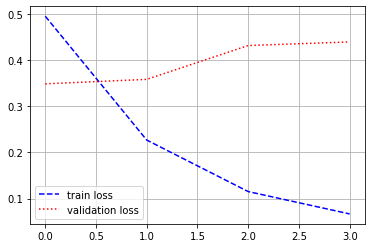

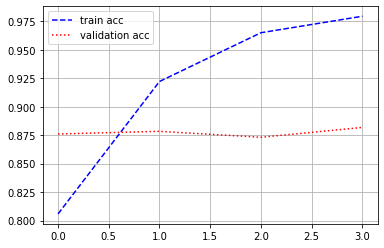

In [ ]:
hist_dict = history.history

loss= hist_dict['loss']
val_loss= hist_dict['val_loss']
acc= hist_dict['acc']
val_acc= hist_dict['val_acc']

plt.plot(loss, 'b--', label='train loss')
plt.plot(val_loss, 'r:', label='validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='train acc')
plt.plot(val_acc, 'r:', label='validation acc')
plt.legend()
plt.grid()

plt.show()

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
sentence_pairs = test[['premise','hypothesis']].values.astype('str')

test_data = ELECTRASemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=len(sentence_pairs), shuffle=False, include_targets=False,
    )

In [ ]:
pred = model.predict(test_data[0])
pred = pred.tolist()

In [ ]:
idx = [np.argmax(x) for x in pred]
prediction = [labels[index] for index in idx] 
print(prediction)
print(idx)

['contradiction', 'entailment', 'entailment', 'contradiction', 'contradiction', 'neutral', 'neutral', 'entailment', 'entailment', 'neutral', 'contradiction', 'entailment', 'contradiction', 'entailment', 'contradiction', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'entailment', 'entailment', 'contradiction', 'contradiction', 'entailment', 'entailment', 'entailment', 'neutral', 'contradiction', 'entailment', 'contradiction', 'neutral', 'neutral', 'contradiction', 'neutral', 'contradiction', 'entailment', 'contradiction', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'contradiction', 'neutral', 'entailment', 'contradiction', 'entailment', 'neutral', 'contradiction', 'entailment', 'neutral', 'neutral', 'entailment', 'neutral', 'neutral', 'entailment', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'neutral', 'contradiction', 'neutral', 'neutral', 'neutral', 'contradiction', 'entailment', 'neutral', 'entailment', 'entailment', 'neut

In [ ]:
test['label'] = prediction

In [ ]:
submit['label'] = test['label']

In [ ]:
tryout = 'dropout_03'

submit.to_csv("/content/drive/MyDrive/DACON/한국어_문장_관계_분류/submit_{}.csv".format(tryout), index = False)


In [ ]:
test

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,neutral
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,contradiction
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,contradiction
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,neutral
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,entailment
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,neutral
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,neutral
